# A test script to measure performance of Autoencoder De-noising

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import chainer
import chainer.functions as F
import chainer.links as L
import chainer.initializers as I

In [2]:
class Regressor(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(Regressor, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return h2

In [110]:
class Regressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(Regressor2, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [3]:
x = np.linspace(-1, 1, 100)

In [186]:
def roll(batchsize=1000):
    def ricker(x,a): return 2 / (np.sqrt(3 * a) * np.pi ** (1/4)) * (1. - x ** 2 / a ** 2) * np.exp(-x ** 2 / 2 / a ** 2)
    return (ricker(x - (np.random.random((batchsize,1)) - 0.5), np.random.random((batchsize,1)) * 0.2 + 0.05)).astype(np.float32)
trainy = roll(10000)

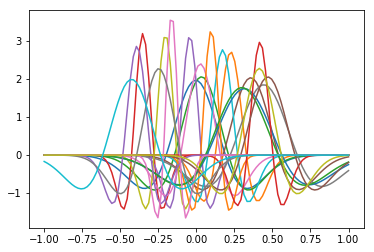

In [204]:
plt.plot(x, trainy[:20,:].T);

In [111]:
def run_train(trainer, epoch=10000, report_period=100, report_period_seconds=0, regularize=0.0001):
    from time import clock
    start = clock()
    last_report = start
    model = Regressor2(trainer().shape[1], 128)

    model.zerograds()

    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer.WeightDecay(regularize))
    loss_hist = []

    for i in range(epoch):
        trainx = trainer()
        trainy = trainer()
        loss = F.mean_squared_error(model(trainx), trainy)
        loss_hist.append(loss.data)
        if i % report_period == 0:
            if last_report + report_period_seconds < clock():
                ups = i / (clock() - start)
                eta = (epoch - i) / ups if ups != 0 else 0
                etas = '%d:%05.2f' % (eta // 60, eta % 60) if 60 < eta else '%.2f' % eta
                print(i, 'loss', loss.data, ', ups: %.2f' % ups, ', eta: ' + etas)
                last_report = clock()
        #optimizer.weight_decay(0.005)
        optimizer.update(lambda x,y: F.mean_squared_error(model(x), y), trainx, trainy)

    return model, loss_hist

In [149]:
model, loss_hist = run_train(lambda: trainy, epoch=3000, report_period=10, report_period_seconds=5, regularize=0.000001)

50 loss 0.06277929246425629 , ups: 9.91 , eta: 4:57.62
100 loss 0.016977375373244286 , ups: 9.93 , eta: 4:51.94
160 loss 0.007284607272595167 , ups: 10.18 , eta: 4:39.01
220 loss 0.004262109752744436 , ups: 10.32 , eta: 4:29.35
280 loss 0.002926476066932082 , ups: 10.42 , eta: 4:21.15
340 loss 0.0021966365166008472 , ups: 10.43 , eta: 4:14.93
400 loss 0.0017448560101911426 , ups: 10.46 , eta: 4:08.53
460 loss 0.0014407768612727523 , ups: 10.49 , eta: 4:02.19
520 loss 0.0012209245469421148 , ups: 10.50 , eta: 3:56.20
580 loss 0.001054988824762404 , ups: 10.50 , eta: 3:50.42
640 loss 0.000926570559386164 , ups: 10.51 , eta: 3:44.46
690 loss 0.0008398574427701533 , ups: 10.47 , eta: 3:40.55
750 loss 0.0007532636518590152 , ups: 10.49 , eta: 3:34.47
810 loss 0.0006808729376643896 , ups: 10.51 , eta: 3:28.44
870 loss 0.0006199674098752439 , ups: 10.52 , eta: 3:22.52
930 loss 0.0005679317400790751 , ups: 10.53 , eta: 3:16.57
990 loss 0.0005231924005784094 , ups: 10.54 , eta: 3:10.75
1050 los

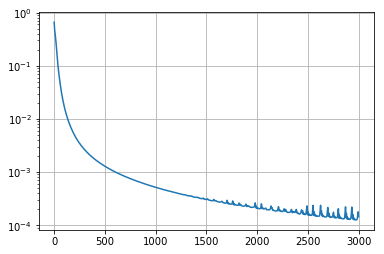

In [150]:
plt.semilogy(loss_hist)
plt.grid();

In [232]:
def moving_average(a, n=3) :
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    return np.concatenate([np.zeros(n // 2), ret[n - 1:] / n, np.zeros(n // 2)], 0)

Noise RMSE= 25.9269 NN RMSE= 8.97983 , MAvg RMSE= 3.69475144219 , SavGol RMSE= 4.5224


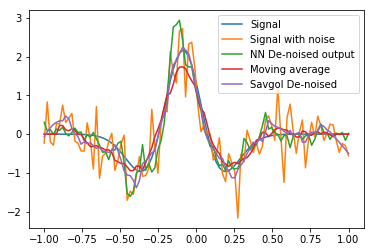

In [242]:
dice = roll(1)
ndice = dice + 0.5 * np.random.normal(size=dice.shape).astype(np.float32)
mavged = moving_average(ndice, 11).reshape((1,-1))
savgoled = sp.signal.savgol_filter(ndice.reshape((-1)), 11, 2).reshape((1,-1))
plt.plot(x, np.vstack([dice, ndice, model(ndice).data, mavged, savgoled]).T);
plt.legend(['Signal', 'Signal with noise', 'NN De-noised output', 'Moving average', 'Savgol De-noised']);
print('Noise RMSE=', ((dice - ndice) ** 2).sum(),
    'NN RMSE=', ((dice - model(ndice).data) ** 2).sum(),
      ', MAvg RMSE=', ((dice - mavged) ** 2).sum(),
      ', SavGol RMSE=', ((dice - savgoled) ** 2).sum())